##### Importing Libraries

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns



# Custom Dataset Class


In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

/tmp/ipykernel_24/3090539249.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))  # Get a colormap with enough colors


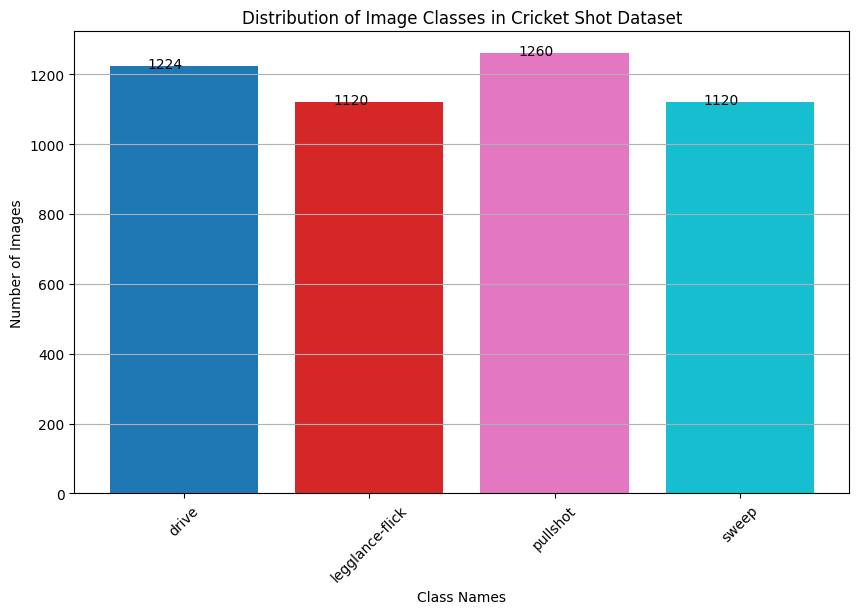

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

data_dir = '/kaggle/input/cricket-shot-dataset/data'
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

# Initialize a list to store counts of images for each class
class_counts = {class_name: 0 for class_name in class_names}

# Count the number of images in each class
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    class_counts[class_name] = len([img_file for img_file in os.listdir(class_dir) 
                                     if img_file.endswith(('.png', '.jpg', '.jpeg', '.webp'))])

# Prepare data for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Define colors for each class (you can choose any color palette you like)
colors = plt.cm.get_cmap('tab10', len(classes))  # Get a colormap with enough colors

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color=[colors(i) for i in range(len(classes))])
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Distribution of Image Classes in Cricket Shot Dataset')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Optionally, add a legend if desired
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() - 5, str(count), 
             ha='center', color='black', fontsize=10)

# Show the plot
plt.show()


# Data Preparation


In [4]:
import os
from PIL import Image

data_dir = '/kaggle/input/cricket-shot-dataset/data'
image_paths = []
labels = []
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

def is_image_corrupted(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify the image
        return False
    except (IOError, SyntaxError) as e:
        print(f"Corrupted image found: {image_path}")
        return True

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        if img_file.endswith(('.png', '.jpg', '.jpeg', '.webp')):
            img_path = os.path.join(class_dir, img_file)
            if not is_image_corrupted(img_path):
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])


In [5]:
data_dir = '/kaggle/input/cricket-shot-dataset/data'
image_paths = []
labels = []
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        if img_file.endswith(('.png', '.jpg', '.jpeg', '.webp')):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(class_to_idx[class_name])

train_paths,test_paths, train_labels, test_labels = train_test_split(image_paths,
                                                                     labels, test_size=0.2,
                                                                     stratify=labels,
                                                                     random_state=42)

## Data Transformations


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

## Dataset and DataLoader

In [7]:
train_dataset = CustomImageDataset(train_paths, train_labels, transform=transform)
test_dataset = CustomImageDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualizing Sample Images


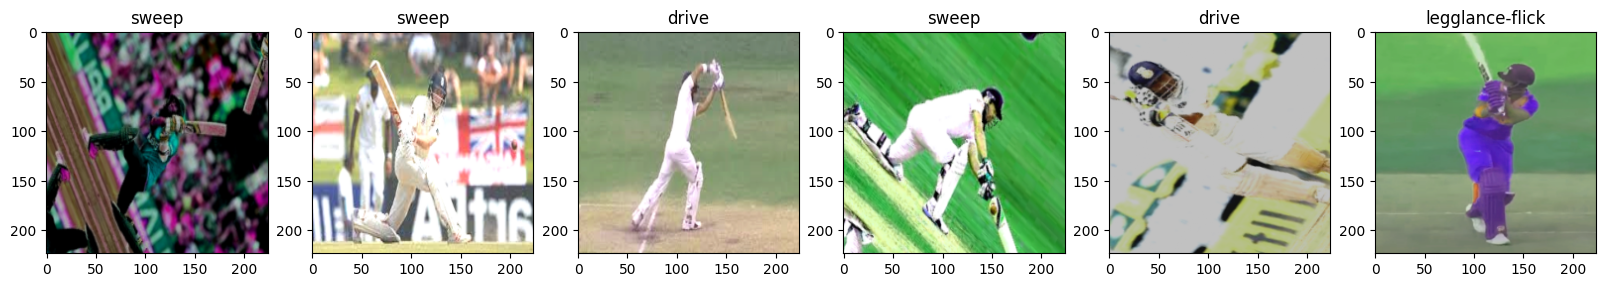

In [8]:
def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        image, label = dataset[i]
        ax = axes[i]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(class_names[label])
    plt.show()

show_images(train_dataset)

# Model Setup

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Comment this line
model = torchvision.models.resnet50(pretrained=True)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 16.6MB/s]


# Model Training

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 0.7356
Epoch 2, Loss: 0.3511
Epoch 3, Loss: 0.3041
Epoch 4, Loss: 0.2363
Epoch 5, Loss: 0.1745
Epoch 6, Loss: 0.3150
Epoch 7, Loss: 0.1994
Epoch 8, Loss: 0.2158
Epoch 9, Loss: 0.0869
Epoch 10, Loss: 0.3441
Epoch 11, Loss: 0.1459
Epoch 12, Loss: 0.0888
Epoch 13, Loss: 0.0327
Epoch 14, Loss: 0.0318
Epoch 15, Loss: 0.0183
Epoch 16, Loss: 0.0516
Epoch 17, Loss: 0.2476
Epoch 18, Loss: 0.0358
Epoch 19, Loss: 0.0404
Epoch 20, Loss: 0.0669


# Model Evaluation

In [11]:
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")



Accuracy: 0.92


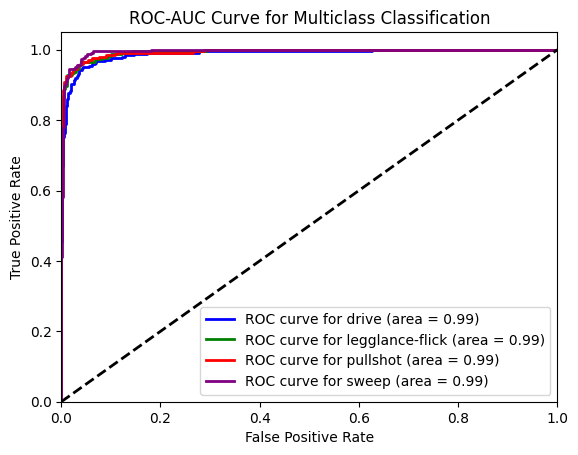

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Assuming your class names
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']
n_classes = len(class_names)

# Collect labels and predicted probabilities
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Binarize the labels for one-vs-rest ROC calculation
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

# Plotting ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = roc_auc_score(all_labels_bin[:, i], np.array(all_probs)[:, i])

# Plot the ROC curve for each class
plt.figure()
colors = ['blue', 'green', 'red', 'purple']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


ROC-AUC for drive: 0.99


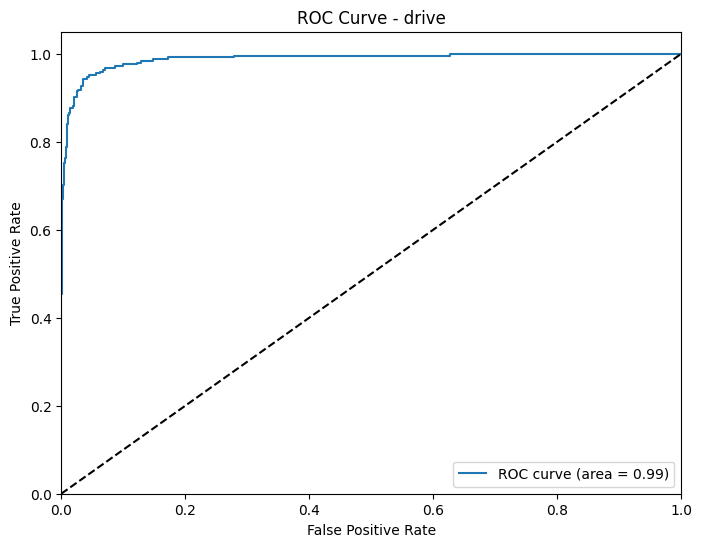

ROC-AUC for legglance-flick: 0.99


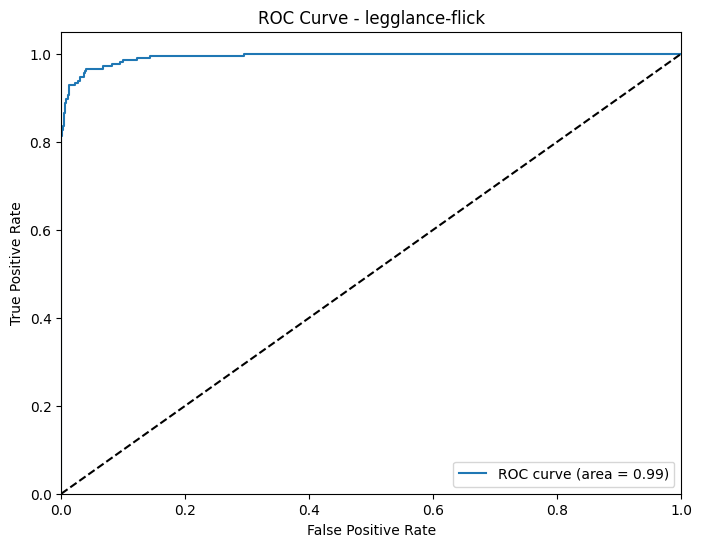

ROC-AUC for pullshot: 0.99


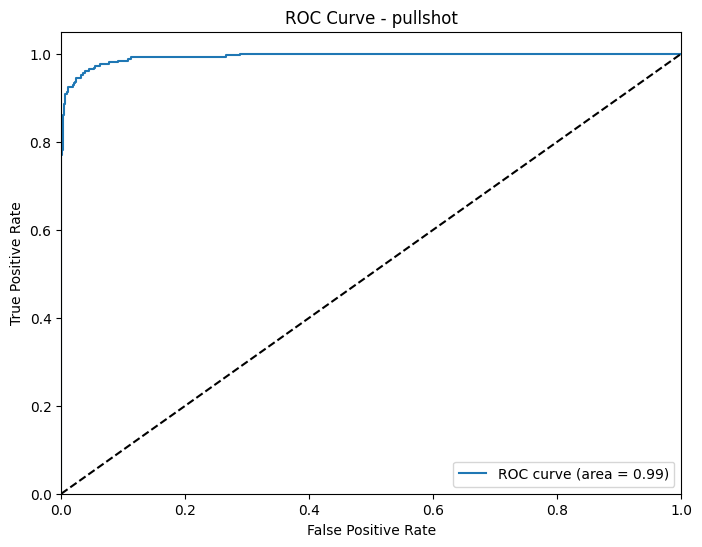

ROC-AUC for sweep: 0.99


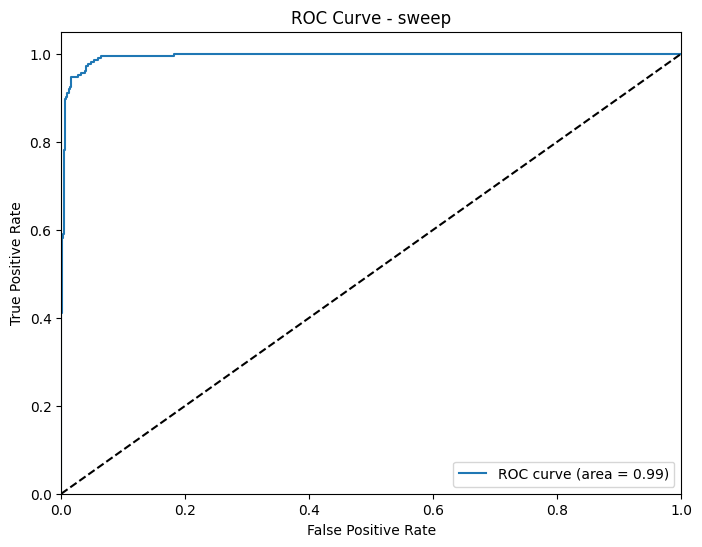

In [13]:
import torch
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Assuming these are your class names
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']

# Evaluate the model and collect predictions and probabilities
model.eval()
all_labels = []
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Probabilities for each class
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # All class probabilities

# Binarize the labels for one-vs-all ROC AUC
all_labels_binarized = label_binarize(all_labels, classes=list(range(len(class_names))))

# Compute ROC-AUC for each class
for i, class_name in enumerate(class_names):
    class_labels = all_labels_binarized[:, i]
    class_probs = [prob[i] for prob in all_probs]
    
    # Compute ROC-AUC
    roc_auc = roc_auc_score(class_labels, class_probs)
    print(f"ROC-AUC for {class_name}: {roc_auc:.2f}")
    
    # Generate ROC curve
    fpr, tpr, thresholds = roc_curve(class_labels, class_probs)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {class_name}')
    plt.legend(loc="lower right")
    plt.show()


In [14]:
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Assuming your class names
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']

# Collect labels and predictions
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get the class with the highest score
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision, recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

# Detailed report for each class
classification_rep = classification_report(all_labels, all_preds, target_names=class_names)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:\n", classification_rep)


Accuracy: 0.92
Precision: 0.93
Recall: 0.92
F1 Score: 0.92

Classification Report:
                  precision    recall  f1-score   support

          drive       0.94      0.88      0.91       245
legglance-flick       0.96      0.92      0.94       224
       pullshot       0.90      0.96      0.93       252
          sweep       0.91      0.95      0.93       224

       accuracy                           0.92       945
      macro avg       0.93      0.92      0.93       945
   weighted avg       0.93      0.92      0.92       945



## Confusion Matrix

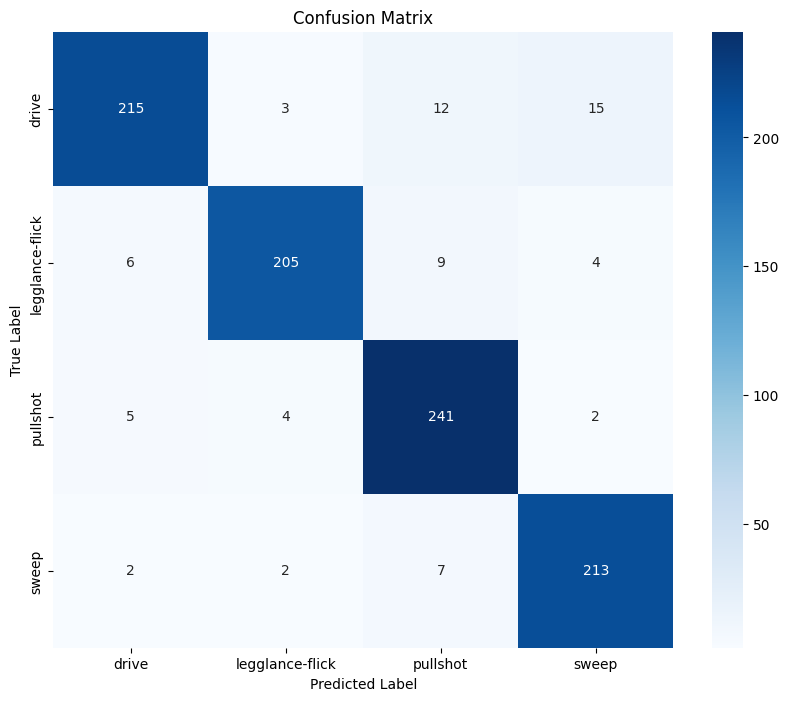

In [15]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
cm = confusion_matrix(all_labels, all_preds)
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Predictions

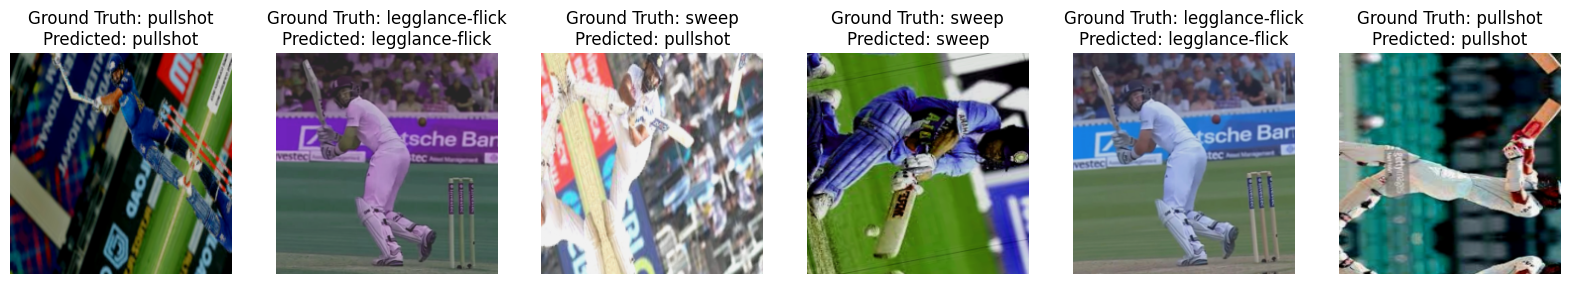

In [16]:
def show_predictions(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        image, true_label = dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            _, pred_label = torch.max(output, 1)
        pred_label = pred_label.item()

        ax = axes[i]
        ax.imshow(image.squeeze().permute(1, 2, 0).cpu())
        ax.set_title(f"Ground Truth: {class_names[true_label]}\nPredicted: {class_names[pred_label]}")
        ax.axis('off')
    plt.show()

show_predictions(test_dataset)

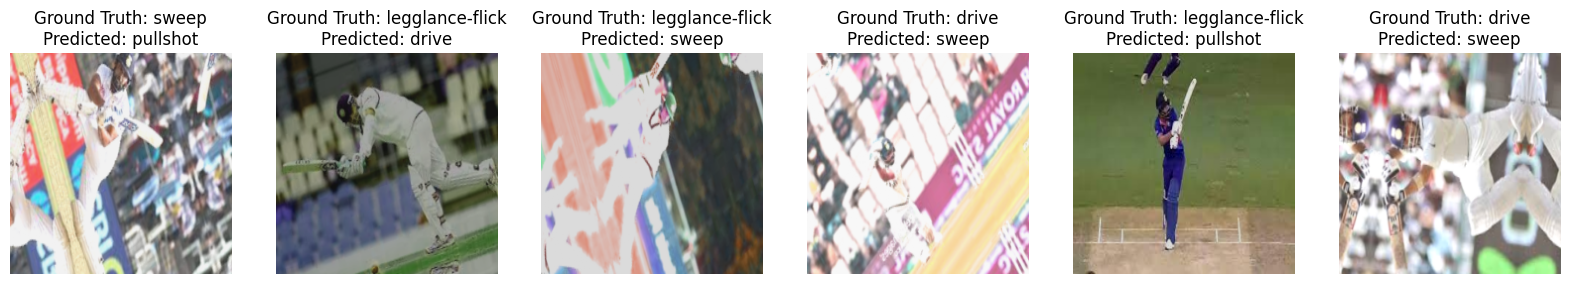

In [17]:
def show_misclassified_predictions(dataset, num_images=6):
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    # Collect misclassified examples
    for i in range(len(dataset)):
        image, true_label = dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            _, pred_label = torch.max(output, 1)
        pred_label = pred_label.item()
        
        # Check if the prediction is wrong
        if pred_label != true_label:
            misclassified_images.append(image.squeeze().cpu())
            misclassified_labels.append(true_label)
            misclassified_preds.append(pred_label)
        
        # Stop if we have collected enough misclassified images
        if len(misclassified_images) == num_images:
            break

    # Plot misclassified images
    fig, axes = plt.subplots(1, len(misclassified_images), figsize=(20, 10))
    for i, ax in enumerate(axes):
        ax.imshow(misclassified_images[i].permute(1, 2, 0))
        true_label = misclassified_labels[i]
        pred_label = misclassified_preds[i]
        ax.set_title(f"Ground Truth: {class_names[true_label]}\nPredicted: {class_names[pred_label]}")
        ax.axis('off')
    
    plt.show()

show_misclassified_predictions(test_dataset)
